

# US Forest Service - Forest Type Predictions
Jonathan Whiteley 

## Competition Description
- Use cartographic variables to classify forest categories 
- https://www.kaggle.com/competitions/forest-cover-type-prediction/overview
- Goal: predict the forest cover type (the predominant kind of tree cover) from cartographic variables 
- Forest cover type is determined by the US Forest Service (USFS) Region 2 Resource Information System data 
- Independent variables derived from data obtained from teh US Geological Survey and USFS 
- Study area includes four wilderness areas located in the Roosevelt National Forest of northern Colorado - forests with minimal human-caused disturbances - forest cover types are a result of ecological processes rather than forest management practices 

## Data Description
- Four wilderness areas located in the Roosevelt National Forest of northern Colorado 
- Each observation is a 30m x 30m patch
- Predict an integer classification for the forest cover type:
    - 1 - Spruce/Fir
    - 2 - Lodgepole Pine
    - 3 - Ponderosa Pine
    - 4 - Cottonwood/Willow
    - 5 - Aspen
    - 6 - Douglas-fir
    - 7 - Krummholz
- The training set (15,120 observations); test set (565,892 observations) 

Another Resource: https://csfs.colostate.edu/colorado-forests/forest-types/ 

In [2]:
#import packages 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns 
import tensorflow as tf
sns.set(style="darkgrid")

from sklearn.model_selection import train_test_split
import random


from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel

from google.colab import drive
drive.mount('/content/drive')

# %cd /content/drive/MyDrive/W207_Final_Project/

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Load, Preprocess, & Split Data

In [ ]:
#read in the data
train_full = pd.read_csv('data/train.csv') 
test = pd.read_csv('data/test.csv')
samplesubmission = pd.read_csv('data/sampleSubmission.csv')

In [ ]:
#looking at the size of the data
print(train_full.shape)
print(test.shape)
print(samplesubmission.shape)

(15120, 56)
(565892, 55)
(565892, 2)


In [ ]:
#Looking at y-variable 
print(train_full.dtypes)

Here we split our full training set into a train and validation set, 70-30 respectively.

In [ ]:
train_full.shape[0]

15120

In [ ]:
#change y-variable from numeric to string 
train_full["Cover_Type"] = train_full["Cover_Type"].apply(str)

#Splitting train data into a train and validation set 70-30
np.random.seed(123)

# Apply random shufflying to training examples.
indices = np.arange(train_full.shape[0])
shuffled_indices = np.random.permutation(indices)
train_full = train_full.iloc[shuffled_indices]

validation, train = train_test_split(
    train_full, train_size=10584, test_size=4536
    )

#create training feature and label arrays
x_train = np.array(train.iloc[:, 1:55])
y_train = np.array(train['Cover_Type'])

#creating validation feature and label arrays
x_validation = np.array(validation.iloc[:, 1:55])
y_validation = np.array(validation['Cover_Type'])

In [ ]:
train.head()

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
7882,7883,3400,340,10,994,61,1338,198,225,166,...,0,0,0,0,0,0,1,0,0,7
893,894,2924,270,10,134,11,5066,194,244,189,...,0,0,0,0,0,0,0,0,0,5
3236,3237,2235,40,28,467,152,524,209,166,75,...,0,0,0,0,0,0,0,0,0,3
10495,10496,3464,42,24,30,0,1804,216,180,88,...,0,0,0,0,0,0,0,1,0,7
2307,2308,2673,255,18,180,20,1298,175,248,209,...,0,1,0,0,0,0,0,0,0,5


# EDA
We create a data dictionary from the data description from Kaggle for easier reference for feature engineering and interpretation. Next we perform EDA to get a better grasp on our variables.

In [ ]:
#@title 
blurb = [['Elevation ', ' Elevation in meters'],
['Aspect ', ' Aspect in degrees azimuth'],
['Slope ', ' Slope in degrees'],
['Horizontal_Distance_To_Hydrology ', ' Horz Dist to nearest surface water features'],
['Vertical_Distance_To_Hydrology ', ' Vert Dist to nearest surface water features'],
['Horizontal_Distance_To_Roadways ', ' Horz Dist to nearest roadway'],
['Hillshade_9am ', ' Hillshade index at 9am, summer solstice'],
['Hillshade_Noon ', ' Hillshade index at noon, summer solstice'],
['Hillshade_3pm', ' Hillshade index at 3pm, summer solstice'],
['Horizontal_Distance_To_Fire_Points ', ' Horz Dist to nearest wildfire ignition points'],
['Wilderness_Area (4 binary columns) ', ' Wilderness area designation'],
['Soil_Type (40 binary columns)', ' Soil Type designation'],
['Cover_Type ', ' Forest Cover Type designation']]

column_names = []
column_desc = []

for d in blurb:
    column_names.append(d[0])
    column_desc.append(d[1])

col_measurement = ["meters",
               "azimuth",
               "degrees",
               "meters",
               "meters",
               "meters",
               "0 to 255 index",
               "0 to 255 index",
               "0 to 255 index",
               "meters",
               "0 = absence or 1 = presence",
               "0 = absence or 1 = presence",
               "Classes numbered 1 to 7"]

data_dictionary = pd.DataFrame(list(zip(column_names, col_measurement, column_desc)),
                         columns = ['Variable', "Measurement", "Description"])

NameError: ignored

### Data Dictionary

In [ ]:
data_dictionary

,Variable,Measurement,Description
0,Elevation,meters,Elevation in meters
1,Aspect,azimuth,Aspect in degrees azimuth
2,Slope,degrees,Slope in degrees
3,Horizontal_Distance_To_Hydrology,meters,Horz Dist to nearest surface water features
4,Vertical_Distance_To_Hydrology,meters,Vert Dist to nearest surface water features
5,Horizontal_Distance_To_Roadways,meters,Horz Dist to nearest roadway
6,Hillshade_9am,0 to 255 index,"Hillshade index at 9am, summer solstice"
7,Hillshade_Noon,0 to 255 index,"Hillshade index at noon, summer solstice"
8,Hillshade_3pm,0 to 255 index,"Hillshade index at 3pm, summer solstice"
9,Horizontal_Distance_To_Fire_Points,meters,Horz Dist to nearest wildfire ignition points


Let's group the columns based on similar names and binary/continuous grouping to get a better understanding of our features

In [ ]:
all_cols = list(train.columns)
area_cols = list(filter(lambda x: x.startswith("Wilderness_Area"), all_cols))
soil_cols = list(filter(lambda x: x.startswith("Soil_Type"), all_cols))

In [ ]:
binary_cols = area_cols + soil_cols
continuous_cols = [x for x in all_cols if x not in binary_cols]                                  

## Histogram plot
Here we can better understand the distribution of our factors. We see the scales differ across continuous variables. We also see that the `Wilderness_Area` and `Soil_Type` factors are binary.

### Continuous Factors

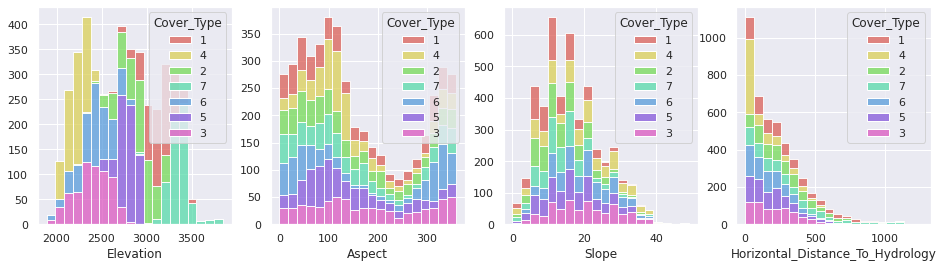

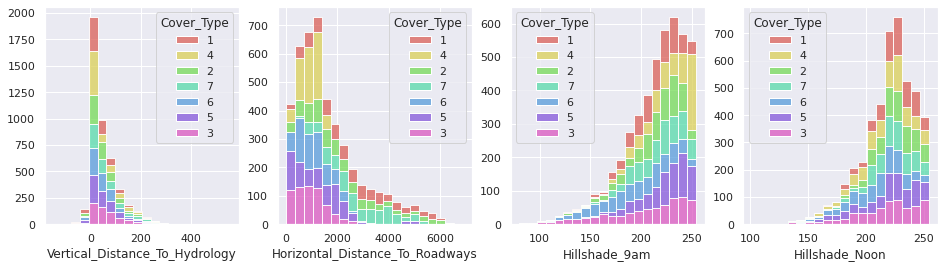

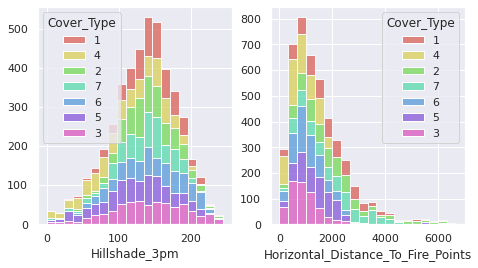

In [ ]:
slot = 0
for col in all_cols:
    
    # skip plotting certain columns 
    if col in ["Id", "Cover_Type"] + soil_cols + area_cols:
        continue

    if slot % 4 == 0:
        plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, slot % 4 + 1)
    
    sns.histplot(data=train, x=col, 
                 hue="Cover_Type",  #tree type based on color hue overlaid
                 bins=20,
                 palette="hls",
                 multiple="stack")
    plt.ylabel("")
    
    if slot % 4 == 3:
        plt.show()
    
    slot += 1

### Binary Factors

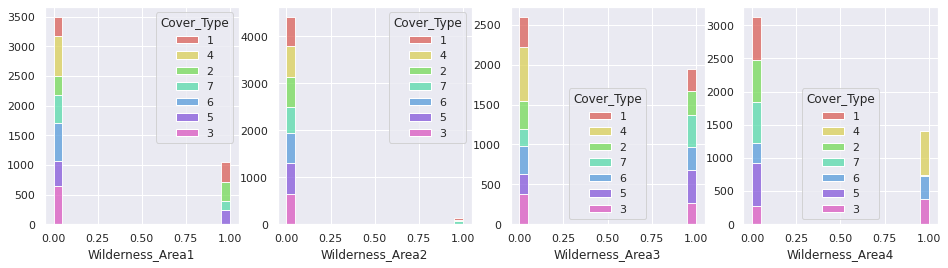

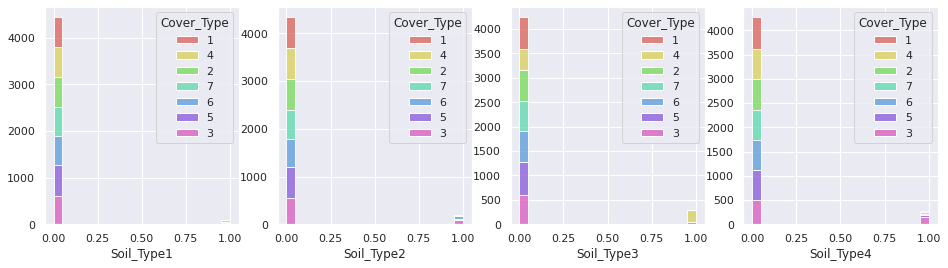

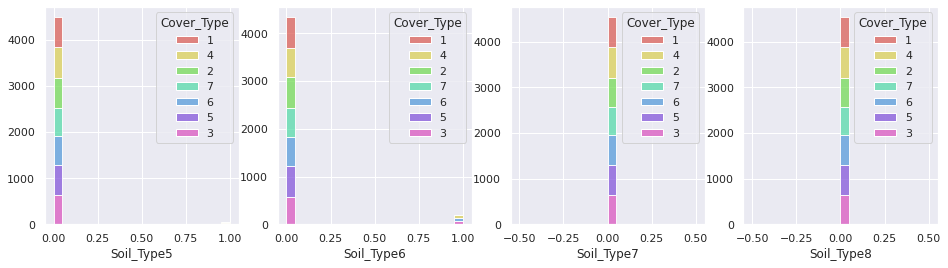

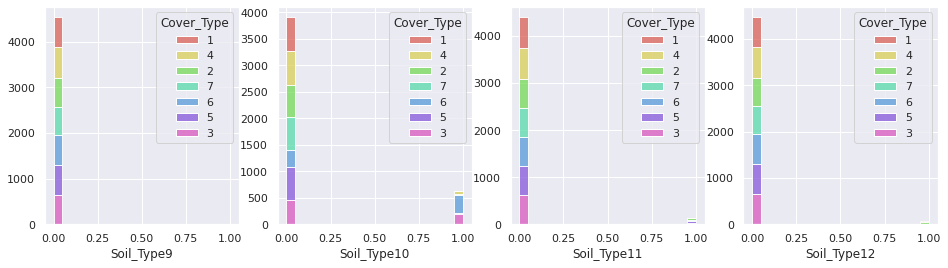

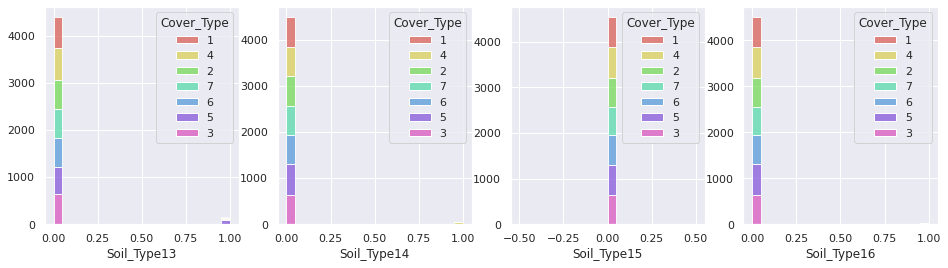

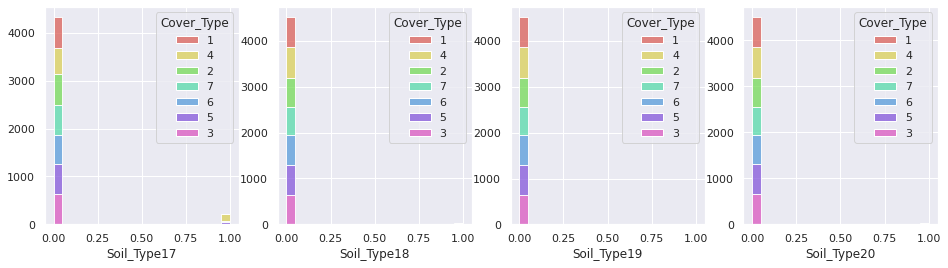

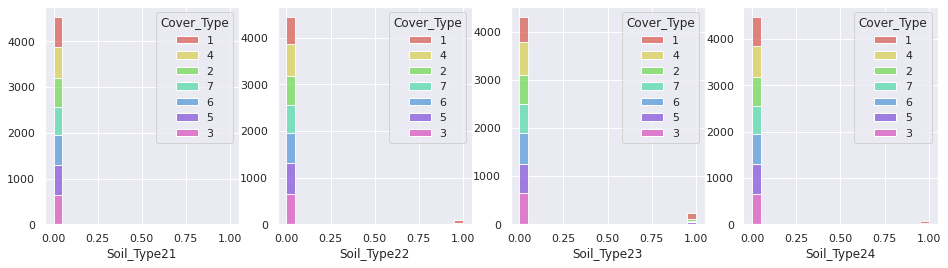

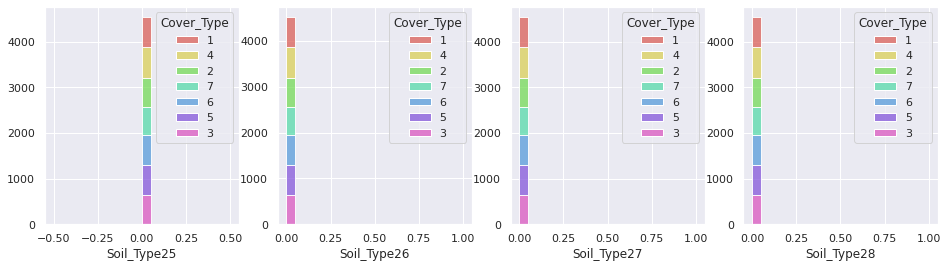

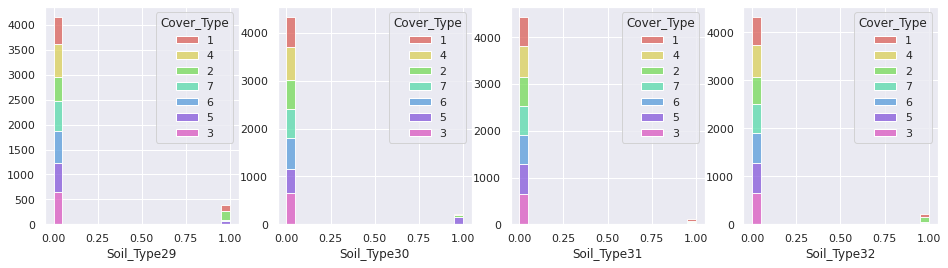

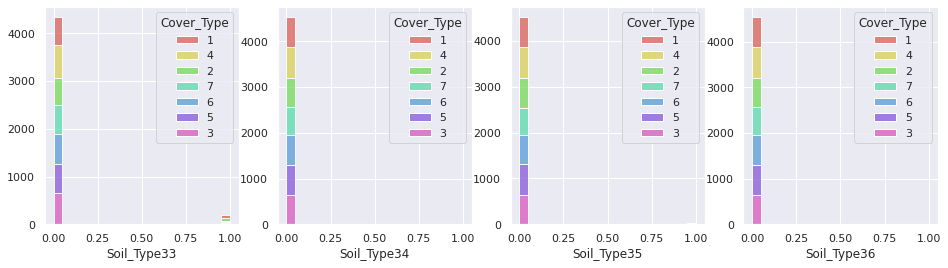

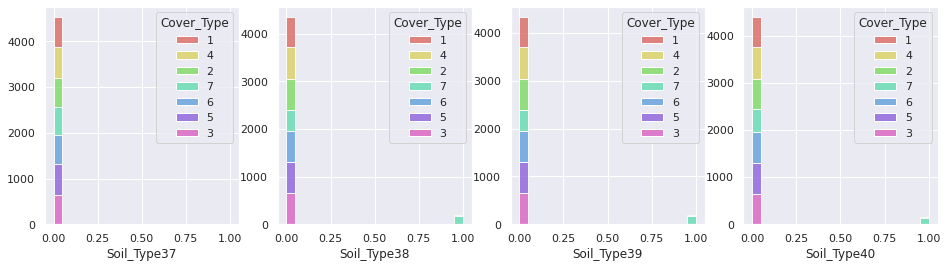

In [ ]:
slot = 0
for col in area_cols +soil_cols:
    
    # skip plotting certain columns 
    if col in ["Id", "Cover_Type"]:
        continue

    if slot % 4 == 0:
        plt.figure(figsize=(16, 4))
    plt.subplot(1, 4, slot % 4 + 1)
    sns.histplot(data=train, x=col, 
                 hue="Cover_Type", bins=20, 
                 palette="hls", multiple="stack")
    plt.ylabel("")
    
    if slot % 4 == 3:
        plt.show()
    
    slot += 1

## Check for missing values
We see there are no missing values in this dataset, with 100% of values as not-NA

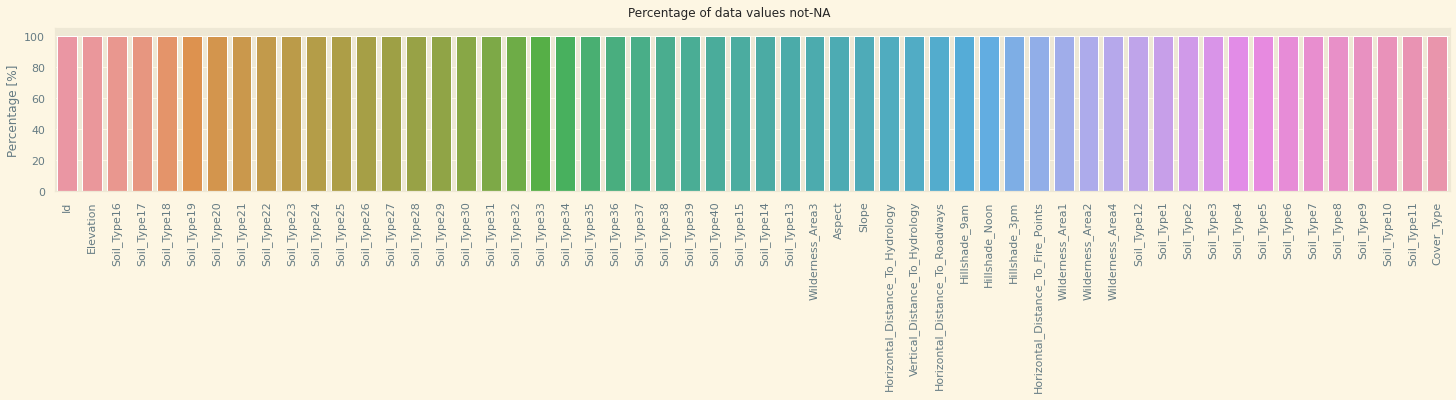

In [ ]:
tmp = train.notna().sum().div(len(train)).mul(100).sort_values(ascending=False)

plt.style.use('Solarize_Light2')
fig, ax = plt.subplots(1,1, figsize=(25,3))
sns.barplot(x=tmp.index, y=tmp.values, ax=ax)
ax.set_ylabel("Percentage [%]")
ax.tick_params(axis='x', rotation=90)
plt.suptitle("Percentage of data values not-NA")

plt.show()

## Distribution of Output Variable
We see here that we have a relatively even count of each tree type in our train set.

In [ ]:
print(len(train['Cover_Type']))
train.groupby(['Cover_Type'])['Cover_Type'].count()

4536


Cover_Type
1    649
2    645
3    648
4    676
5    660
6    643
7    615
Name: Cover_Type, dtype: int64

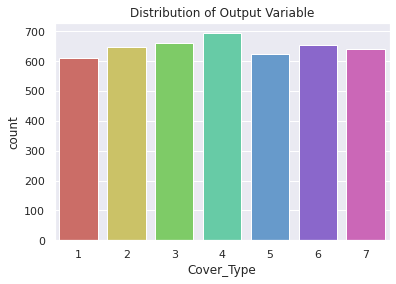

In [ ]:
sns.countplot(x=train['Cover_Type'].sort_values(ascending=True), 
              palette="hls").set(title='Distribution of Output Variable')

plt.show()

## Correlations

The correlation matrix highlights some interesting results, yet nothing shocking. The relationship between hillshades at different times of day & Aspect or Slope makes sense. As does the relationship between Horizontal and Vertical distance to hydrology. Some additional feature engineering could be interesting here on these continuous columns

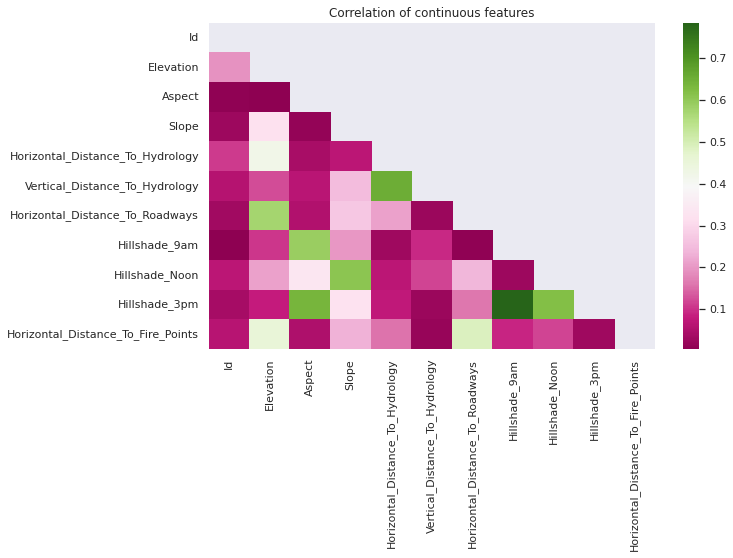

In [ ]:
## Correlation matrix for continuous features - easy to read/interpret

correlations = train[continuous_cols].corr().abs()

mask=np.triu(np.ones_like(correlations))

fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.heatmap(correlations, ax=ax, mask=mask, cmap="PiYG")
ax.set_title("Correlation of continuous features")
plt.show()

Lets examine `elevation` with other features a bit more...

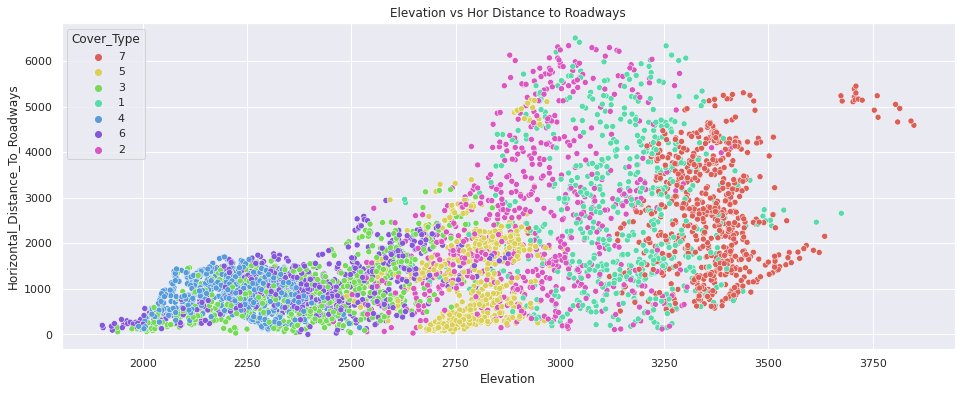

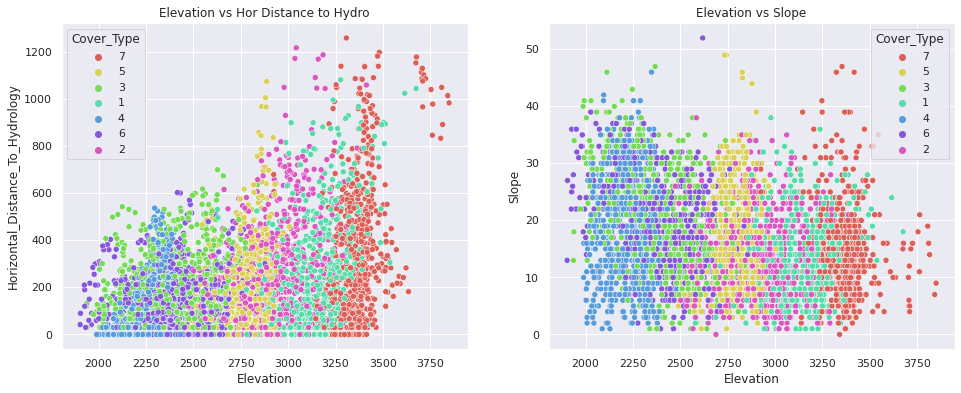

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Elevation vs Hor Distance to Roadways')
sns.scatterplot(x='Elevation', 
                    y='Horizontal_Distance_To_Roadways', 
                    data=train, 
                    hue="Cover_Type",  #tree type based on color hue overlaid
                    palette="hls")


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))

ax1.set_title('Elevation vs Hor Distance to Hydro')
sns.scatterplot(x='Elevation', 
                    y='Horizontal_Distance_To_Hydrology', 
                    data=train, 
                    hue="Cover_Type",  #tree type based on color hue overlaid
                    palette="hls",
                ax=ax1)

ax2.set_title('Elevation vs Slope')
sns.scatterplot(x='Elevation', 
                y='Slope', 
                data=train, 
                hue="Cover_Type",  #tree type based on color hue overlaid
                palette="hls",
                ax=ax2)
plt.show()

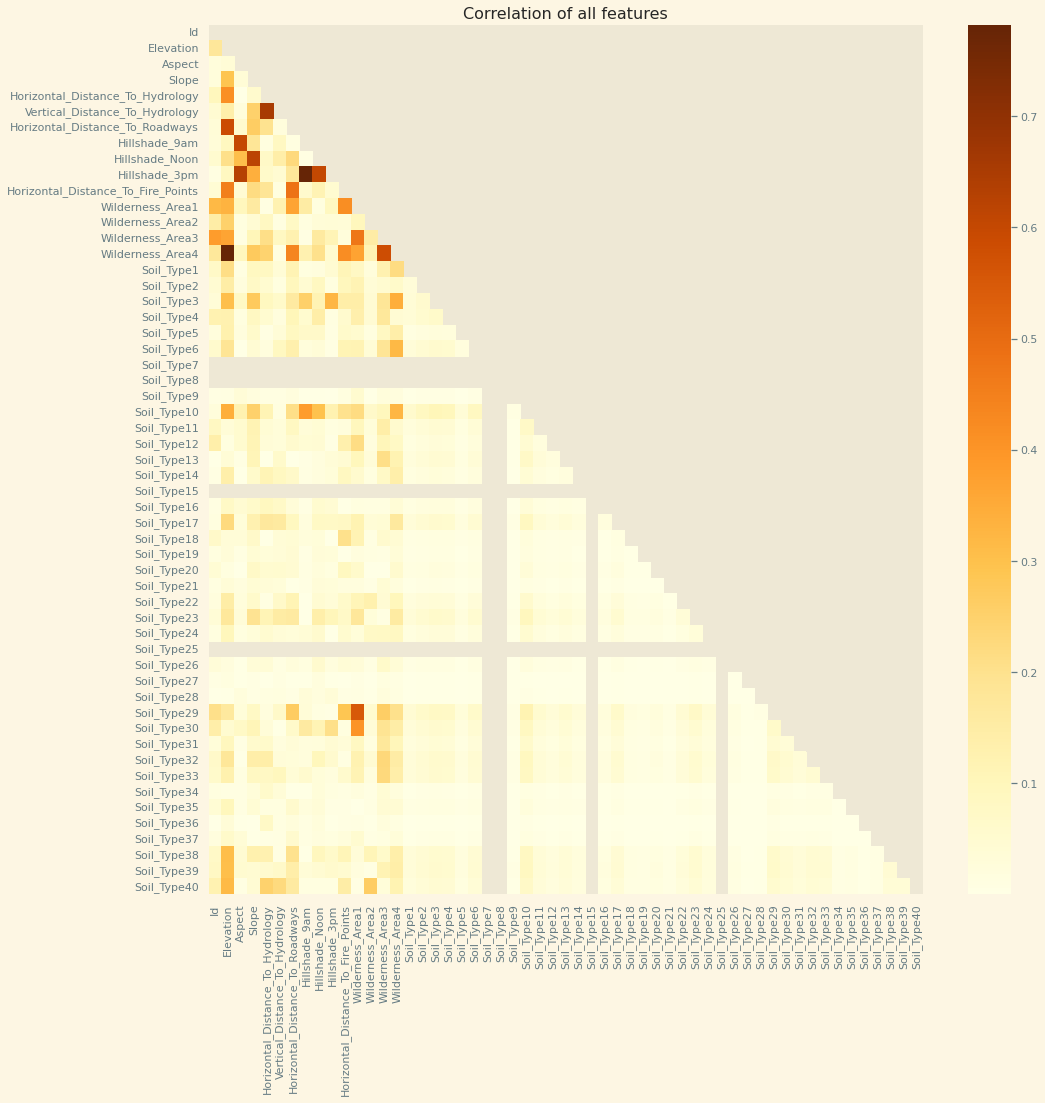

In [ ]:
## All features
correlations_all = train.corr().abs()

mask=np.triu(np.ones_like(correlations_all))

fig, ax = plt.subplots(1,1, figsize=(16,16))
sns.heatmap(correlations_all, ax=ax, mask=mask, cmap="PiYG")
ax.set_title("Correlation of all features")
plt.show()

## Choice of Metric

Our metric of performance is accuracy because unlike precision and recall, it accounts for all misclassification. This is important because incorrectly classifying cover types could be detrimental to the environmental care initiatives of the US Forest Service (USFS). In addition to practical significance, since our problem isn't a largely imbalanced classification problem (such as cancer detection) there doesnt seem to be as much of a need to augment with precision or recall. 

# Baseline Models

## 1. KNN

In [ ]:
#putting the data into the format needed for KNN 

train_Y = train.iloc[: , 55]
#looking at just numeric variables rather than also binary variables
train_X = train.iloc[: , 1:11]
train_X_array = train_X.to_numpy()
train_Y_array = train_Y.to_numpy()

validation_Y = validation.iloc[: , 55]
validation_X = validation.iloc[: , 1:11]
validation_X_array = validation_X.to_numpy()
validation_Y_array = validation_Y.to_numpy()

In [ ]:
#sklearn knn function


#reading in the necessary package
from sklearn.neighbors import KNeighborsClassifier

#setting the classifier 
neigh = KNeighborsClassifier(n_neighbors=3)

#fitting the model to the data 
neigh.fit(train_X_array, train_Y_array)

#getting predictions for each validation observation
neigh.predict(validation_X_array)

#getting the mean accuracy for the train set
print(round(neigh.score(train_X_array, train_Y_array),4))

#getting the mean accuracy for the validation set 
print(round(neigh.score(validation_X_array, validation_Y_array),4))

0.8803
0.7436


|K|Train Accuracy|Validation Accuracy|
|-|-|-|
|**1**|**1.0**|**0.7701**|
|2|0.9187|0.7383|
|**3**|**0.8803**|**0.7436**|
|4|0.8596|0.7332|
|5|0.8393|0.7267|
|7|0.8051|0.7173|


From testing out a variety of K values, it seems that K=1 and K=3 are the best. We may choose k=3 to make sure our model is not overfit, as it may be with only one nearest neighbor. 

In [ ]:
#trying out same model with normalization

train_X_array_means = np.mean(train_X_array, axis=0)
train_X_array_stds = np.std(train_X_array, axis=0)
train_X_array_normalized = (train_X_array - train_X_array_means) / train_X_array_stds
validation_X_array_normalized = (validation_X_array - train_X_array_means)/ train_X_array_stds

In [ ]:
#sklearn knn function


#reading in the necessary package
from sklearn.neighbors import KNeighborsClassifier

#setting the classifier 
neigh = KNeighborsClassifier(n_neighbors=3)

#fitting the model to the data 
neigh.fit(train_X_array_normalized, train_Y_array)

#getting predictions for each validation observation
neigh.predict(validation_X_array_normalized)

#getting the mean accuracy for the train set
print(round(neigh.score(train_X_array_normalized, train_Y_array),4))

#getting the mean accuracy for the validation set 
print(round(neigh.score(validation_X_array_normalized, validation_Y_array),4))

0.8419
0.6786


|K|Train Accuracy|Validation Accuracy|
|-|-|-|
|**1**|**1.0**|**0.6846**|
|2|0.8743|0.6497|
|**3**|**0.8419**|**0.6786**|
|4|0.8113|0.6633|
|5|0.7930|0.6675|
|7|0.7650|0.6611|

From testing out a variety of K values after normalization, it seems that K=1 and K=3 are the best. We may choose k=3 to make sure our model is not overfit, as it may be with only one nearest neighbor. It is interesting that the model performed bettter before the data was normalized. This is likely just luck that the variables that are larger may have more of an impact on the output variable than other variables.

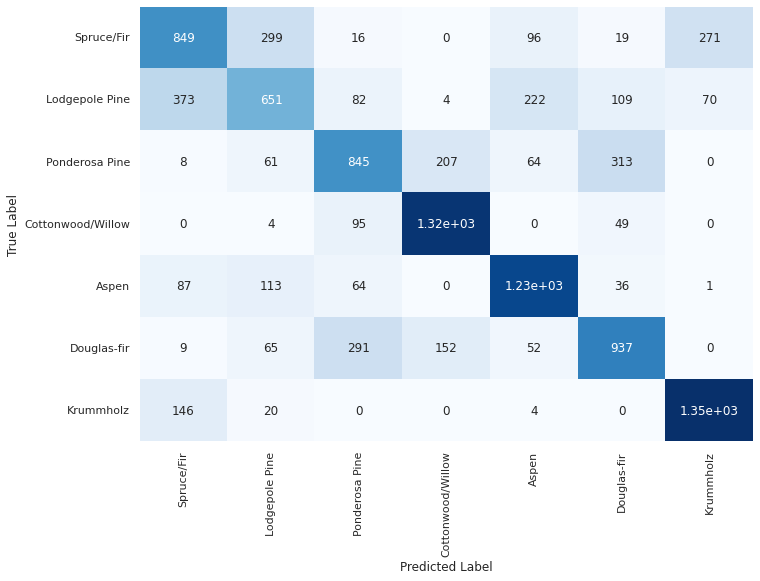

In [ ]:
#try to look into what we are getting wrong and why 

from sklearn.metrics import confusion_matrix
import seaborn
sns.set(rc={'figure.figsize':(11,8)})

label_names = ['Spruce/Fir','Lodgepole Pine','Ponderosa Pine','Cottonwood/Willow','Aspen','Douglas-fir','Krummholz']
validation_Y_array_predicted = neigh.predict(validation_X_array_normalized)

validation_Y_array_v2 = list(map(int, validation_Y_array))
validation_Y_array_v2 = np.array(validation_Y_array_v2)
validation_Y_array_v2 = validation_Y_array_v2.astype('uint8') 
validation_Y_array_v2 = validation_Y_array_v2-1

validation_Y_array_predicted_v2 = list(map(int, validation_Y_array_predicted))
validation_Y_array_predicted_v2 = np.array(validation_Y_array_predicted_v2)
validation_Y_array_predicted_v2 = validation_Y_array_predicted_v2.astype('uint8') 
validation_Y_array_predicted_v2 = validation_Y_array_predicted_v2-1

confusion_matrix = tf.math.confusion_matrix(validation_Y_array_v2, validation_Y_array_predicted_v2)

# Confusion Matrix Mapping 
sns.set(rc={'figure.figsize':(11,8)})
confusion_matrix = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)
confusion_matrix.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()


**Our best KNN model is the normalized model with k=3, having a train accuracy of 0.8419 and a validation accuracy of 0.6786.**

## 2. Logistic Regression

In [ ]:
#data splitting into x and y for respective training and validation
train, validation = train_test_split(train_full, train_size=10584, test_size=4536)

#create training feature and label arrays
X = np.array(train.iloc[:, 1:55])
Y = np.array(train['Cover_Type'])
Y = Y-1

#creating validation feature and label arrays
Xval = np.array(validation.iloc[:, 1:55])
Yval = np.array(validation['Cover_Type'])
Yval= Yval-1

In [ ]:
#model creation
model2 = LogisticRegression(multi_class='ovr').fit(X,Y)

#getting predictions on validation set
log_test_preds = model2.predict(Xval).astype(int)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
#printing model performance
print(f'Accuracy: {round(model2.score(X,Y),3)} \nValidation Accuracy: {round(model2.score(Xval,Yval),3)} ')

Accuracy: 0.576 
Validation Accuracy: 0.566 


| penalty | multi_class|Training Accuracy| Validation Accuracy|
| --- | --- | --- |--- |
|L2| 'ovr'| 0.576|0.566
|L2| 'multinomial'| 0.488|0.481

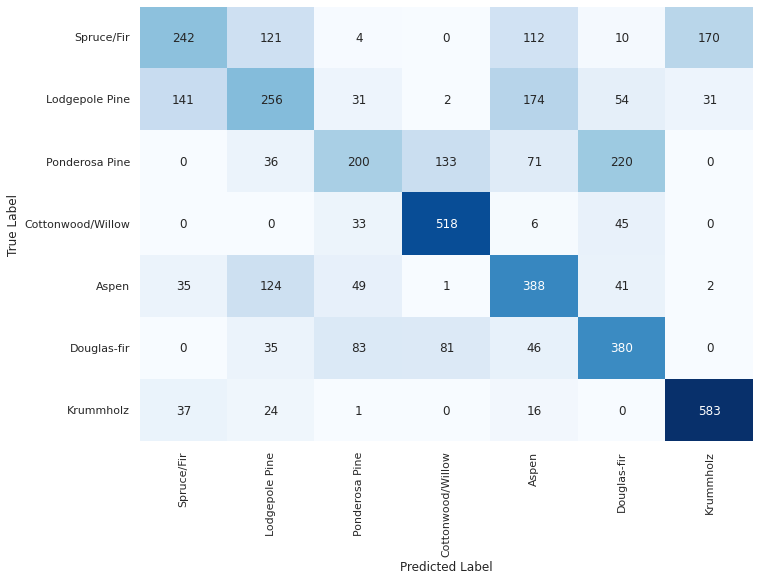

In [ ]:
log_confusion_matrix = tf.math.confusion_matrix(Yval, log_test_preds)
label_names = ['Spruce/Fir','Lodgepole Pine','Ponderosa Pine','Cottonwood/Willow','Aspen','Douglas-fir','Krummholz']

# Confusion Matrix Mapping
sns.set(rc={'figure.figsize':(11,8)})
log_confusion = sns.heatmap(log_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

log_confusion.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

## Summary

Our team is aiming to develop an ML model that optimally classifies Forest Cover Types.

The preliminary approaches taken to classify are K-Nearest Neighbors and Multiclass Logistic Regression. The accuracy achieved by the KNN model is 68%, while logistic model was only able to accurately classify 54% .

Going forward, we plan to build and implement different models to improve accuracy above the baseline.

# Additional Models

## 3. Random Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html  

In [ ]:
#putting the data into the format needed for random forest

train_Y = train.iloc[: , 55]
train_X = train.iloc[: , 1:55]
train_X_array = train_X.to_numpy()
train_Y_array = train_Y.to_numpy()

validation_Y = validation.iloc[: , 55]
validation_X = validation.iloc[: , 1:55]
validation_X_array = validation_X.to_numpy()
validation_Y_array = validation_Y.to_numpy()

In [ ]:
#fixing Y array types 
train_Y_array_v2 = list(map(int, train_Y_array))
train_Y_array_v2 = np.array(train_Y_array_v2)
train_Y_array_v2 = train_Y_array_v2.astype('uint8') 
train_Y_array_v2 = train_Y_array_v2-1

validation_Y_array_v2 = list(map(int, validation_Y_array))
validation_Y_array_v2 = np.array(validation_Y_array_v2)
validation_Y_array_v2 = validation_Y_array_v2.astype('uint8') 
validation_Y_array_v2 = validation_Y_array_v2-1

In [ ]:
#sklearn random forest function 

#reading in the necessary package
from sklearn.ensemble import RandomForestClassifier

#setting the random forest classifier 
#random_forest = RandomForestClassifier(max_depth=2, random_state=0)
random_forest = RandomForestClassifier(max_depth=None, random_state=0)

#fitting the model to the data
random_forest.fit(train_X_array, train_Y_array_v2)

#getting predictions for each validation observation 
random_forest.predict(validation_X_array)

#getting the mean accuracy for the train set
print(round(random_forest.score(train_X_array, train_Y_array_v2),4))

#getting the mean accuracy for the validation set 
print(round(random_forest.score(validation_X_array, validation_Y_array_v2),4))

1.0
0.8156


In [ ]:
#working on further tuning the random forest model 

#n_estimators - number of trees in the forest
#max_features = max number of features considered for splitting a node
#max_depth = max number of levels in each decision tree
#min_samples_split = min number of data points placed in a node before the node is split
#min_samples_leaf = min number of data points allowed in a leaf node
#bootstrap = method for sampling data points (with or without replacement)

#default settings:
#random_forest = RandomForestClassifier(max_depth=None, random_state=0, n_estimators=100, min_samples_split=2, min_samples_leaf=1, bootstrap = True, max_features='sqrt')

#other options: 
#random_forest = RandomForestClassifier(max_depth=10, random_state=0, n_estimators=100, min_samples_split=2, min_samples_leaf=1, bootstrap = True, max_features='sqrt')
#random_forest = RandomForestClassifier(max_depth=20, random_state=0, n_estimators=100, min_samples_split=2, min_samples_leaf=1, bootstrap = True, max_features='sqrt')
#random_forest = RandomForestClassifier(max_depth=30, random_state=0, n_estimators=100, min_samples_split=2, min_samples_leaf=1, bootstrap = True, max_features='sqrt')
#random_forest = RandomForestClassifier(max_depth=40, random_state=0, n_estimators=100, min_samples_split=2, min_samples_leaf=1, bootstrap = True, max_features='sqrt')
random_forest = RandomForestClassifier(max_depth=30, random_state=0, n_estimators=200, min_samples_split=2, min_samples_leaf=1, bootstrap = True, max_features='sqrt')
#random_forest = RandomForestClassifier(max_depth=30, random_state=0, n_estimators=300, min_samples_split=2, min_samples_leaf=1, bootstrap = True, max_features='sqrt')
#random_forest = RandomForestClassifier(max_depth=30, random_state=0, n_estimators=200, min_samples_split=5, min_samples_leaf=1, bootstrap = True, max_features='sqrt')
#random_forest = RandomForestClassifier(max_depth=30, random_state=0, n_estimators=200, min_samples_split=10, min_samples_leaf=1, bootstrap = True, max_features='sqrt')
#random_forest = RandomForestClassifier(max_depth=30, random_state=0, n_estimators=200, min_samples_split=2, min_samples_leaf=2, bootstrap = True, max_features='sqrt')
#random_forest = RandomForestClassifier(max_depth=30, random_state=0, n_estimators=200, min_samples_split=2, min_samples_leaf=4, bootstrap = True, max_features='sqrt')
#random_forest = RandomForestClassifier(max_depth=30, random_state=0, n_estimators=200, min_samples_split=2, min_samples_leaf=1, bootstrap = False, max_features='sqrt')
#random_forest = RandomForestClassifier(max_depth=30, random_state=0, n_estimators=200, min_samples_split=2, min_samples_leaf=1, bootstrap = True, max_features=None)

random_forest.fit(train_X_array, train_Y_array_v2)
random_forest.predict(validation_X_array)
print(round(random_forest.score(train_X_array, train_Y_array_v2),4))
print(round(random_forest.score(validation_X_array, validation_Y_array_v2),4))

1.0
0.8187


|max_depth|random_state|n_estimators|min_samples_split|min_samples_leaf|bootstrap|max_features|Train Accuracy|Validation Accuracy|
|-|-|-|-|-|-|-|-|-|
|None|0|100|2|1|True|'sqrt'|1.0|0.8156|
|10|0|100|2|1|True|'sqrt'|0.8946|0.7712|
|20|0|100|2|1|True|'sqrt'|0.9998|0.8121|
|30|0|100|2|1|True|'sqrt'|1.0|0.8160|
|40|0|100|2|1|True|'sqrt'|1.0|0.8156|
|**30**|**0**|**200**|**2**|**1**|**True**|**'sqrt'**|**1.0**|**0.8187**|
|30|0|300|2|1|True|'sqrt'|1.0|0.8171|
|30|0|200|5|1|True|'sqrt'|0.9932|0.8147|
|30|0|200|10|1|True|'sqrt'|0.9641|0.8059|
|30|0|200|2|2|True|'sqrt'|0.9797|0.8109|
|30|0|200|2|4|True|'sqrt'|0.9248|0.7970|
|30|0|200|2|1|False|'sqrt'|1.0|0.8222|
|30|0|200|2|1|True|None|1.0|0.8038|

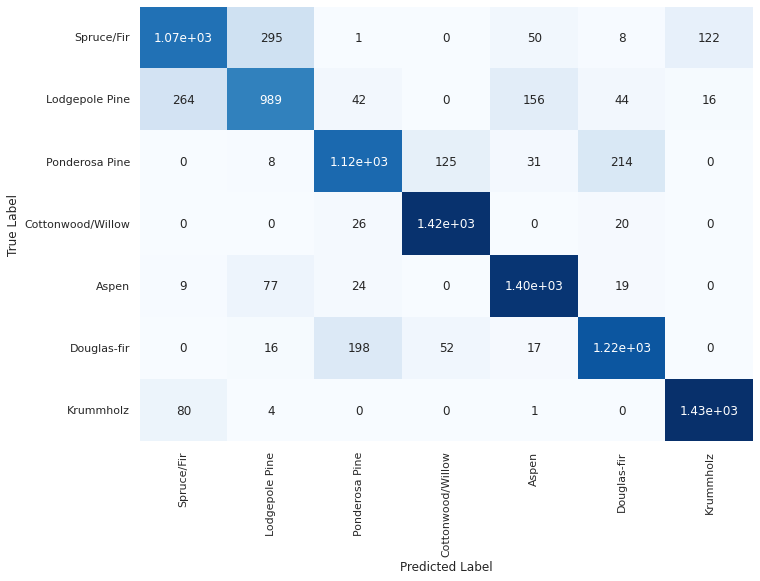

In [ ]:
#try to look into what we are getting wrong and why 
from sklearn.metrics import confusion_matrix
import seaborn
sns.set(rc={'figure.figsize':(11,8)})

label_names = ['Spruce/Fir','Lodgepole Pine','Ponderosa Pine','Cottonwood/Willow','Aspen','Douglas-fir','Krummholz']
validation_Y_array_predicted = random_forest.predict(validation_X_array)
confusion_matrix = tf.math.confusion_matrix(validation_Y_array_v2, validation_Y_array_predicted)

# Confusion Matrix Mapping 
sns.set(rc={'figure.figsize':(11,8)})
confusion_matrix = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)
confusion_matrix.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

It seems that we misclassify 1's as 0's and 0's as 1's a large amount. We also misclassify 2's as 5's and 5's as 2's a large amount.

In [ ]:
#1. is a 1 but is labeled 0
X_validation_filtered = np.logical_and(validation_Y_array_v2 == 1, validation_Y_array_predicted == 0)
X_validation_filtered = validation_X[X_validation_filtered]
#print((X_validation_filtered))
#print(X_validation_filtered.mean())

#1. is a 0 but is labeled 1
X_validation_filtered = np.logical_and(validation_Y_array_v2 == 0, validation_Y_array_predicted == 1)
X_validation_filtered = validation_X[X_validation_filtered]
#print((X_validation_filtered))
#print(X_validation_filtered.mean())

**Our best Random Forest model is the bolded model above, with a train accuracy of 1.0 and a validation accuracy of 0.8187.**

## 4. Gradient Boosting

In [ ]:
#data splitting into x and y for respective training and validation
train, validation = train_test_split(train_full, train_size=10584, test_size=4536)

#create training feature and label arrays
X = np.array(train.iloc[:, 1:55])
Y = np.array(train['Cover_Type'])

#creating validation feature and label arrays
Xval = np.array(validation.iloc[:, 1:55])
Yval = np.array(validation['Cover_Type'])

In [ ]:
#model iterations
#gbmodel = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0).fit(X,Y)
#gbmodel = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=1, random_state=0).fit(X,Y)
#gbmodel = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=1, random_state=0).fit(X,Y)
#gbmodel = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=2, random_state=0).fit(X,Y)
#gbmodel = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, max_depth=55, random_state=0).fit(X,Y)
#gbmodel = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, loss='deviance', max_depth=55, random_state=0).fit(X,Y) -- best performing gb model
#gbmodel = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, loss='deviance', max_depth=50, random_state=0).fit(X,Y)
gbmodel = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, loss='deviance', max_depth=3, random_state=0).fit(X,Y)


#getting training and validation accuracy
print('Training Accuracy:',gbmodel.score(X,Y), 'Validation Accuracy:',gbmodel.score(Xval,Yval))

Training Accuracy: 0.8473167044595616 Validation Accuracy: 0.7885802469135802


### Gradient Boost Model Iterations: 

| n_estimators | Learning rate |Loss|Max Depth |Training Accuracy | Validation Accuracy
| --- | --- | --- |--- |--- |--- |
| 100| 0.10| log_loss| 1 | 0.72| 0.69
| 100| 0.01| log_loss| 1| 0.63|0.60
| 1000| 0.10|log_loss|1| 0.79|0.73
| 1000| 0.10|log_loss|2| 0.93|0.81
| 1000| 0.10|log_loss|55| 1|0.81
| 1000| 0.10|deviance|55| 1|0.83
|100| 0.10|deviance|50| 1|0.80
|100| 0.10|deviance|3| 0.85|0.79

### Best Gradient Boosting Performance


In [ ]:
best_gbmodel = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.1, loss='deviance', max_depth=55, random_state=0).fit(X,Y)
gb_preds = best_gbmodel.predict(Xval)

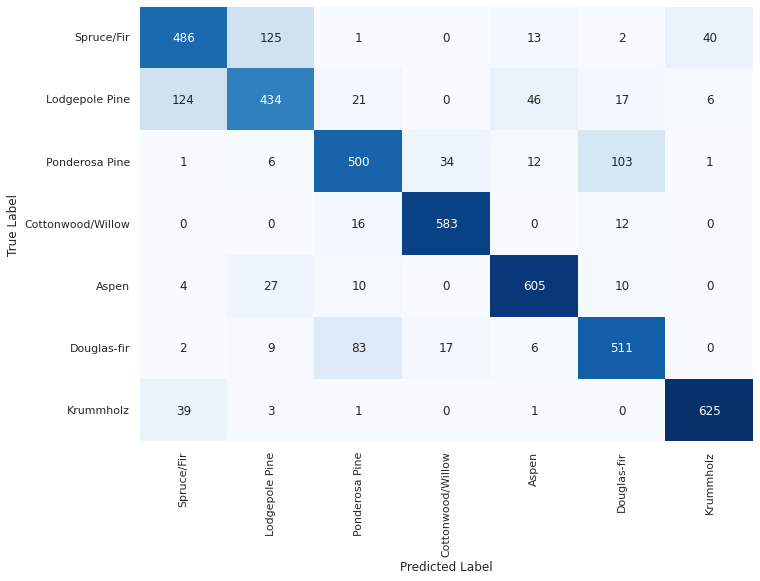

In [ ]:
gb_confusion_matrix = tf.math.confusion_matrix(Yval, gb_preds)
label_names = ['Spruce/Fir','Lodgepole Pine','Ponderosa Pine','Cottonwood/Willow','Aspen','Douglas-fir','Krummholz']

# Confusion Matrix Mapping
sns.set(rc={'figure.figsize':(11,8)})
gb_confusion = sns.heatmap(gb_confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

gb_confusion.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

## 5. XGBoost

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. 

In [ ]:
# Simple model with defaults, no tuning yet

default_model = XGBClassifier(max_depth=3,                #Maximum tree depth for base learners
                      learning_rate=0.1, 
                      n_estimators=100,           #Number of trees to fit.
                      silent=False,
                      objective='multi:softmax',  #since multi-class, we use softmax
                      booster='gbtree',           #gbtree use tree based models while gblinear uses linear functions.
                      n_jobs=1,                   #Number of parallel threads used to run xgboost.
                      gamma=0,                    #Minimum loss reduction required to make a further partition on a leaf node of the tree.
                      min_child_weight=1,         #Minimum sum of instance weight(hessian) needed in a child.
                      max_delta_step=0,           # Maximum delta step we allow each tree's weight estimation to be.
                      subsample=1,                #Subsample ratio of the training instance.
                      colsample_bytree=1,         #Subsample ratio of columns when constructing each tree.
                      colsample_bylevel=1,        #Subsample ratio of columns for each level.
                      reg_alpha=0,                #L1 regularization term on weights
                      reg_lambda=1,               #L2 regularization term on weight
                      scale_pos_weight=1,         #Balancing of positive and negative weights.
                      base_score=0.5,             #The initial prediction score of all instances, global bias.
                      random_state=1234          #setting seed for replication

                      )

default_model.fit(x_train, y_train)

XGBClassifier(objective='multi:softprob', random_state=1234, silent=False)

In [ ]:
y_pred_default = default_model.predict(x_validation)

In [ ]:
accuracy = accuracy_score(y_validation, y_pred_default)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 75.13%


## XGBoost Params to Tune
- `max_depth` : Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit.
- `learning_rate`: Step size shrinkage used in update to prevents overfitting. After each boosting step, we can directly get the weights of new features, and it shrinks the feature weights to make the boosting process more conservative.
- `n_estimators`: Number of trees to fit.
- `subsample`: Subsample ratio of the training instances. Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. Subsampling will occur once in every boosting iteration.

### Compile & Fit Model for each set of Params

In [ ]:
# Define parameter options as lists

p_max_depth = [5, 10, 15]
p_learning_rate = [0.01, 0.1, 0.5]
p_n_estimators = [50, 100, 200]
# scores will go here
results = []

# test for all combinations
for max_depth in p_max_depth:
    for learning_rate in p_learning_rate:
        for n_estimators in p_n_estimators:
            
            #compile model
            model = XGBClassifier(
                max_depth=max_depth,          #Maximum tree depth for base learners
                learning_rate=learning_rate,  
                n_estimators=n_estimators,    #Number of trees to fit.
                objective='multi:softprob',    #since multi-class, we use softprob
                booster='gbtree',             #use tree based models instead of linear functions.
                subsample=0.5,                #randomly sample half of the training data prior to growing trees
                random_state=1234,             #setting seed for replication
                verbose=2
                )
            
            # Train the model
            model.fit(x_train, y_train)
            
            y_pred = model.predict(x_validation)
            # Append current results
            results.append({
                'Val_Accuracy': round(accuracy_score(y_validation, y_pred), 3),
                'P_max_depth': max_depth,
                'P_learning_rate': learning_rate,
                'P_n_estimators': n_estimators
            })
            


### Top 5 Models by Accuracy

In [ ]:
results = pd.DataFrame(results)
results = results.sort_values(by='Val_Accuracy', ascending=False)
results.head()

,Val_Accuracy,P_max_depth,P_learning_rate,P_n_estimators
14,0.815,10,0.1,200
23,0.814,15,0.1,200
13,0.813,10,0.1,100
22,0.812,15,0.1,100
25,0.806,15,0.5,100


### Best Model - Learning Curve

Model #14 returned the highest accuracy, at just over 81.5%. Let's plot its progress with a learning curve.

In [ ]:
best_params = [10,	0.10,	200]

xgb_model = XGBClassifier(
                max_depth=best_params[0],
                learning_rate=best_params[1],
                n_estimators=best_params[2],
                objective='multi:softmax',    #since multi-class, we use softmax
                booster='gbtree',             #use tree based models instead of linear functions.
                subsample=0.5,                #randomly sample half of the training data prior to growing trees
                random_state=1234             #setting seed for replication
                )

# use mlogloss as evaluation metric
eval_set = [(x_train, y_train), (x_validation, y_validation)]
xgb_model.fit(x_train, y_train, eval_metric="mlogloss", eval_set=eval_set, verbose=False)

y_pred_final = xgb_model.predict(x_validation)
print('Val_Accuracy:', round(accuracy_score(y_validation, y_pred_final), 3))

Val_Accuracy: 0.815


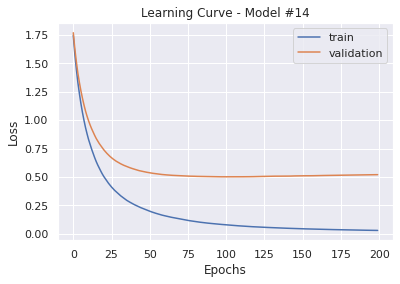

In [ ]:
# retrieve performance metrics
perf_results = xgb_model.evals_result()
# plot learning curves with labels
plt.plot(perf_results['validation_0']['mlogloss'], label='train')
plt.plot(perf_results['validation_1']['mlogloss'], label='validation')
plt.title("Learning Curve - Model #14")
plt.ylabel("Loss")
plt.xlabel("Epochs")

plt.legend()
plt.show()

## Early Stopping to Mitigate Overfitting

It appears that not much progress is being made in terms of validation loss after epoch 100 or so. Let's adjust XGBoost's `early_stopping_rounds` parameter. This will allow us to specify a window of the number of epochs over which no improvement is observed (10% here). 

In [ ]:
# train model now with early stopping
xgb_model.fit(x_train, y_train, early_stopping_rounds=10, eval_metric="mlogloss", eval_set=eval_set, verbose=False)

y_pred_final = xgb_model.predict(x_validation)
print('Val_Accuracy:', round(accuracy_score(y_validation, y_pred_final), 3))

Val_Accuracy: 0.813


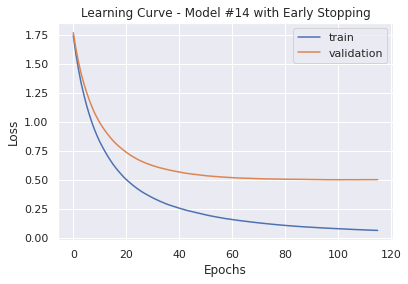

In [ ]:
# retrieve performance metrics
perf_results_early = xgb_model.evals_result()
# plot learning curves
plt.plot(perf_results_early['validation_0']['mlogloss'], label='train')
plt.plot(perf_results_early['validation_1']['mlogloss'], label='validation')
plt.title("Learning Curve - Model #14 with Early Stopping")

plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

We see almost the same accuracy but now the stopping close to the threshold we saw before.

In [ ]:
labels_for_y = ['Spruce/Fir','Lodgepole Pine','Ponderosa Pine','Cottonwood/Willow','Aspen','Douglas-fir','Krummholz']


In [ ]:
cm = confusion_matrix(y_validation, y_pred_final)
cm

array([[1056,  319,    1,    0,   42,    7,  125],
       [ 282,  957,   37,    0,  170,   44,   21],
       [   0,   14, 1115,  116,   42,  211,    0],
       [   0,    0,   28, 1418,    0,   20,    0],
       [   6,   71,   23,    0, 1416,   18,    0],
       [   0,   24,  182,   46,   29, 1225,    0],
       [  96,    5,    0,    0,    3,    0, 1415]])

In [ ]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = labels_for_y, 
                     columns = labels_for_y)

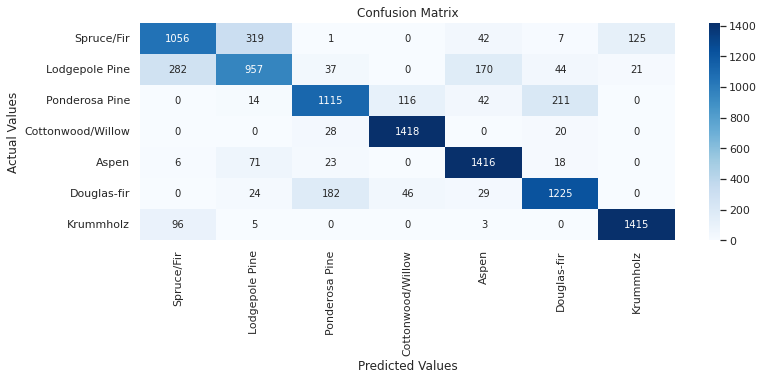

In [ ]:
#Plotting the confusion matrix
plt.figure(figsize=(12,4))
sns.heatmap(cm_df, annot=True, cmap="Blues", fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

We can see that our model was fairly consistent in identifying labels 4, 5, and 7 forest types. 

It struggled the most identifying observations with an actual Label of 2, misclassifying many as either Label 1 or Label 5. 

In fact in predicting observations with an actual Label of 1 or 2, it mixed them up about 30% of the time. 

# Neural Network 

## sklearn

In [ ]:
#putting the data into the format needed for neural networks 

train_Y = train.iloc[: , 55]
train_X = train.iloc[: , 1:55]
train_X_array = train_X.to_numpy()
train_Y_array = train_Y.to_numpy()

validation_Y = validation.iloc[: , 55]
validation_X = validation.iloc[: , 1:55]
validation_X_array = validation_X.to_numpy()
validation_Y_array = validation_Y.to_numpy()

In [ ]:
from sklearn.neural_network import MLPClassifier

#solver can be adam, sgd, L-BFGS - adam seems to perform best 
#clf = MLPClassifier(hidden_layer_sizes=(100), activation = 'relu', solver='adam', alpha=0.0001, batch_size = 'auto', learning_rate = 'constant', max_iter = 200, shuffle = True, random_state=1)
clf = MLPClassifier(hidden_layer_sizes=(50,50,50,50,50,50,50,50), activation = 'relu', solver='adam', alpha=0.0001, batch_size = 'auto', learning_rate = 'constant', max_iter = 200, shuffle = True, random_state=1)


#fitting the model to the data
clf.fit(train_X_array, train_Y_array)

#getting predictions for each validation observation 
clf.predict(validation_X_array)

#getting the mean accuracy for the train set
print(round(clf.score(train_X_array, train_Y_array),4))

#getting the mean accuracy for the validation set 
print(round(clf.score(validation_X_array, validation_Y_array),4))

0.8241
0.7361


In [ ]:
#normalize numeric variables 

train_Y = train.iloc[: , 55]
#looking at just numeric variables rather than also binary variables
train_X = train.iloc[: , 1:11]
train_X_array = train_X.to_numpy()
train_Y_array = train_Y.to_numpy()

validation_Y = validation.iloc[: , 55]
validation_X = validation.iloc[: , 1:11]
validation_X_array = validation_X.to_numpy()
validation_Y_array = validation_Y.to_numpy()

train_X_array_means = np.mean(train_X_array, axis=0)
train_X_array_stds = np.std(train_X_array, axis=0)
train_X_array_normalized = (train_X_array - train_X_array_means) / train_X_array_stds
validation_X_array_normalized = (validation_X_array - train_X_array_means)/ train_X_array_stds

In [ ]:
#combined normalized numeric variable with binary variables 
train_X_2 = train.iloc[: , 11:55]
train_X_2_array = train_X_2.to_numpy()

validation_X_2 = validation.iloc[: , 11:55]
validation_X_2_array = validation_X_2.to_numpy()

train_X_array_normalized_long = np.concatenate((train_X_array_normalized,train_X_2_array),axis=1)
validation_X_array_normalized_long = np.concatenate((validation_X_array_normalized,validation_X_2_array),axis=1)


In [ ]:
from sklearn.neural_network import MLPClassifier

#solver can be adam, sgd, L-BFGS - adam seems to perform best 
clf = MLPClassifier(hidden_layer_sizes=(100, 100), activation = 'relu', solver='adam', alpha=0.0001, batch_size = 'auto', learning_rate = 'constant', learning_rate_init = 0.001, max_iter = 200, shuffle = True, random_state=1)

#fitting the model to the data
clf.fit(train_X_array_normalized_long, train_Y_array)

#getting predictions for each validation observation 
clf.predict(validation_X_array_normalized_long)

#getting the mean accuracy for the train set
print(round(clf.score(train_X_array_normalized_long, train_Y_array),4))

#getting the mean accuracy for the validation set 
print(round(clf.score(validation_X_array_normalized_long, validation_Y_array),4))

0.9663
0.783


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


|activation|solver|learning_rate|max_iter|hidden_layer_sizes|Train Accuracy|Validation Accuracy|
|-|-|-|-|-|-|-|
|relu|adam|0.001|200|(100,)|0.8790|0.7756|
|tanh|adam|0.001|200|(100,)|0.8474|0.7717|
|relu|sgd|0.001|200|(100,)|0.7136|0.6935|
|relu|adam|0.01|200|(100,)|0.9729|0.7707|
|relu|adam|0.0001|200|(100,)|0.7383|0.7063|
|relu|adam|0.001|100|(100,)|0.8408|0.7628|
|relu|adam|0.001|300|(100,)|0.9076|0.7790|
|relu|adam|0.001|400|(100,)|0.9222|0.7786|
|relu|adam|0.001|200|(50,)|0.8404|0.7674|
|**relu**|**adam**|**0.001**|**200**|**(100, 100)**|**0.9663**|**0.7830**|
|relu|adam|0.001|200|(50, 50)|0.9021|0.7750|
|relu|adam|0.001|200|(100, 100, 100)|0.9843|0.7772|
|relu|adam|0.001|300|(100, 100)|0.9868|0.7820|



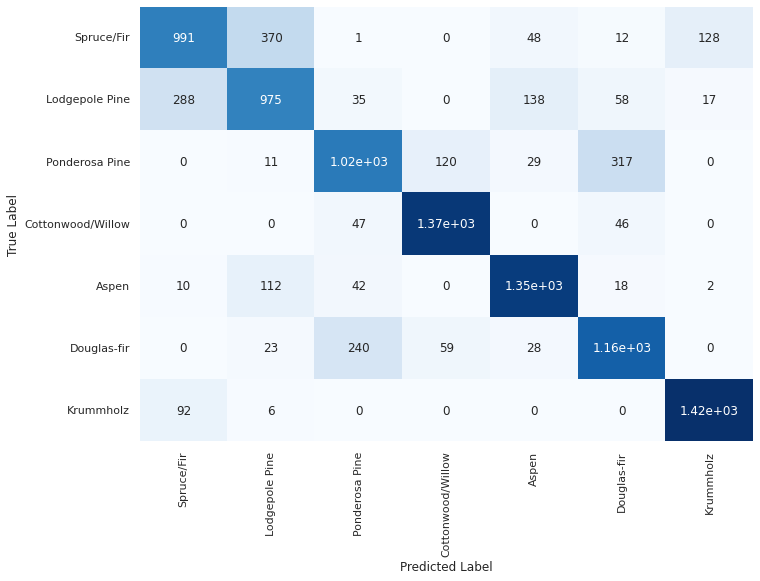

In [ ]:
#try to look into what we are getting wrong and why 
from sklearn.metrics import confusion_matrix
import seaborn
sns.set(rc={'figure.figsize':(11,8)})

label_names = ['Spruce/Fir','Lodgepole Pine','Ponderosa Pine','Cottonwood/Willow','Aspen','Douglas-fir','Krummholz']
validation_Y_array_predicted = clf.predict(validation_X_array_normalized_long)

validation_Y_array_v2 = list(map(int, validation_Y_array))
validation_Y_array_v2 = np.array(validation_Y_array_v2)
validation_Y_array_v2 = validation_Y_array_v2.astype('uint8') 
validation_Y_array_v2 = validation_Y_array_v2-1

validation_Y_array_predicted_v2 = list(map(int, validation_Y_array_predicted))
validation_Y_array_predicted_v2 = np.array(validation_Y_array_predicted_v2)
validation_Y_array_predicted_v2 = validation_Y_array_predicted_v2.astype('uint8') 
validation_Y_array_predicted_v2 = validation_Y_array_predicted_v2-1

confusion_matrix = tf.math.confusion_matrix(validation_Y_array_v2, validation_Y_array_predicted_v2)

# Confusion Matrix Mapping 
sns.set(rc={'figure.figsize':(11,8)})
confusion_matrix = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)
confusion_matrix.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

**Our best Neural Network model is the bolded model above, with a train accuracy of 0.9663 and a validation accuracy of 0.7830.**

# Kaggle Submission

### Gradient Boosting

In [ ]:
final_test_preds = best_gbmodel.predict(test.iloc[:, 1:55])
gb_submission = pd.DataFrame()
gb_submission['ID'] = test.iloc[:,0]
gb_submission['Cover_Type'] = final_test_preds
gb_submission.reset_index(drop=True)
final_csv = gb_submission.to_csv('W207_Project_Data/gb_submission_output.csv')

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


### Random Forest

In [ ]:
#Kaggle RF 

test_X = test.iloc[: , 1:55]
test_X_array = test_X.to_numpy()

final_test_preds = random_forest.predict(test_X_array)
final_test_preds = final_test_preds + 1

test_id = test.iloc[:, 0]
test_id_array = test_id.to_numpy()
test_id_array

test_submit = test[['Id']]
test_submit['Cover_Type'] = final_test_preds
test_submit

final_csv_RF = test_submit.to_csv('W207_Project_Data/rf_submission_output.csv')

### Neural Network

In [ ]:
#Kaggle Neural Network 

test_X = test.iloc[: , 1:11]
test_X_array = test_X.to_numpy()
test_X_array_normalized = (test_X_array - train_X_array_means)/ train_X_array_stds

#combined normalized numeric variable with binary variables 
test_X_2 = test.iloc[: , 11:55]
test_X_2_array = test_X_2.to_numpy()
test_X_array_normalized_long = np.concatenate((test_X_array_normalized,test_X_2_array),axis=1)


final_test_preds = clf.predict(test_X_array_normalized_long)
#final_test_preds = final_test_preds + 1

test_id = test.iloc[:, 0]
test_id_array = test_id.to_numpy()
test_id_array

test_submit = test[['Id']]
test_submit['Cover_Type'] = final_test_preds
test_submit

final_csv_NN = test_submit.to_csv('W207_Project_Data/NN_submission_output.csv')

## XGBoost

In [ ]:
x_test = np.array(test.iloc[:, 1:55])
y_pred_test = xgb_model.predict(x_test)

test_submit = test[['Id']]
test_submit['Cover_Type'] = y_pred_test
test_submit['Cover_Type'] = test_submit['Cover_Type'].astype(int)

test_submit.to_csv('/content/drive/MyDrive/W207_Final_Project/XGBoost_submission.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
